# Part 1 ‐ Exploratory data analysis:

><font color='green'>**Problem Statement**-
>
>The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.
>
</font>


In [1]:
%reset -f

Import Libraries:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

Import Data and Wrangle:

In [3]:
df = pd.read_json('logins.json',convert_dates=["login_time"])
df['login_count'] = 1
df.set_index('login_time',inplace=True)
df['time'] = pd.to_datetime(df.index)

In [4]:
df.head()

,login_count,time
login_time,,
1970-01-01 20:13:18,1,1970-01-01 20:13:18
1970-01-01 20:16:10,1,1970-01-01 20:16:10
1970-01-01 20:16:37,1,1970-01-01 20:16:37
1970-01-01 20:16:36,1,1970-01-01 20:16:36
1970-01-01 20:26:21,1,1970-01-01 20:26:21


In [5]:
df['time'].describe(datetime_is_numeric=True)

count                            93142
mean     1970-02-26 19:09:39.779648278
min                1970-01-01 20:12:16
25%         1970-02-04 10:37:19.750000
50%         1970-03-01 06:33:05.500000
75%         1970-03-22 04:01:10.750000
max                1970-04-13 18:57:38
Name: time, dtype: object

There has been 93142 recorded logins in this dataset. The first login date is January 1st 1970 and the last login date is April 13th 1970 (last 2 weeks missing from April).

### Exploratory Data Analysis:

In [6]:
# Aggregate as the sum of instances over 15 min:

df15 = df.resample('15Min', label='right', closed='right').sum()

In [7]:
df15.head(10)

,login_count
login_time,
1970-01-01 20:15:00,2
1970-01-01 20:30:00,6
1970-01-01 20:45:00,9
1970-01-01 21:00:00,7
1970-01-01 21:15:00,1
1970-01-01 21:30:00,4
1970-01-01 21:45:00,0
1970-01-01 22:00:00,4
1970-01-01 22:15:00,9


In [8]:
df15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:15:00 to 1970-04-13 19:00:00
Freq: 15T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


In [9]:
df15.isnull().sum().any()

False

In [10]:
# Extract necessary features from the timestamp:

df15['time'] = pd.to_datetime(df15.index)        # create a column specifying time
df15['hour'] = df15.time.dt.hour                 # create a column specifying hour
df15['day'] = df15.time.dt.day                   # create a column specifying the day
df15['week'] = df15.time.dt.isocalendar().week   # create a column specifying the weeknumber in the year
df15['weekday'] = df15.time.dt.day_name(locale = 'English')          # create a column specifying the dayname (Monday to Friday)
df15['month'] = df15.time.dt.month_name()              # create a column specifying the Month

In [11]:
df15.head()

,login_count,time,hour,day,week,weekday,month
login_time,,,,,,,
1970-01-01 20:15:00,2,1970-01-01 20:15:00,20,1,1,Thursday,January
1970-01-01 20:30:00,6,1970-01-01 20:30:00,20,1,1,Thursday,January
1970-01-01 20:45:00,9,1970-01-01 20:45:00,20,1,1,Thursday,January
1970-01-01 21:00:00,7,1970-01-01 21:00:00,21,1,1,Thursday,January
1970-01-01 21:15:00,1,1970-01-01 21:15:00,21,1,1,Thursday,January


### Login Activity across the hours in a Day:

In [12]:
dfhour= df.resample('1H', label='right', closed='right').sum()
dfhour['time'] = pd.to_datetime(dfhour.index)
dfhour['hour'] = dfhour.time.dt.hour
dfhour.head()

,login_count,time,hour
login_time,,,
1970-01-01 21:00:00,24,1970-01-01 21:00:00,21
1970-01-01 22:00:00,9,1970-01-01 22:00:00,22
1970-01-01 23:00:00,21,1970-01-01 23:00:00,23
1970-01-02 00:00:00,58,1970-01-02 00:00:00,0
1970-01-02 01:00:00,53,1970-01-02 01:00:00,1


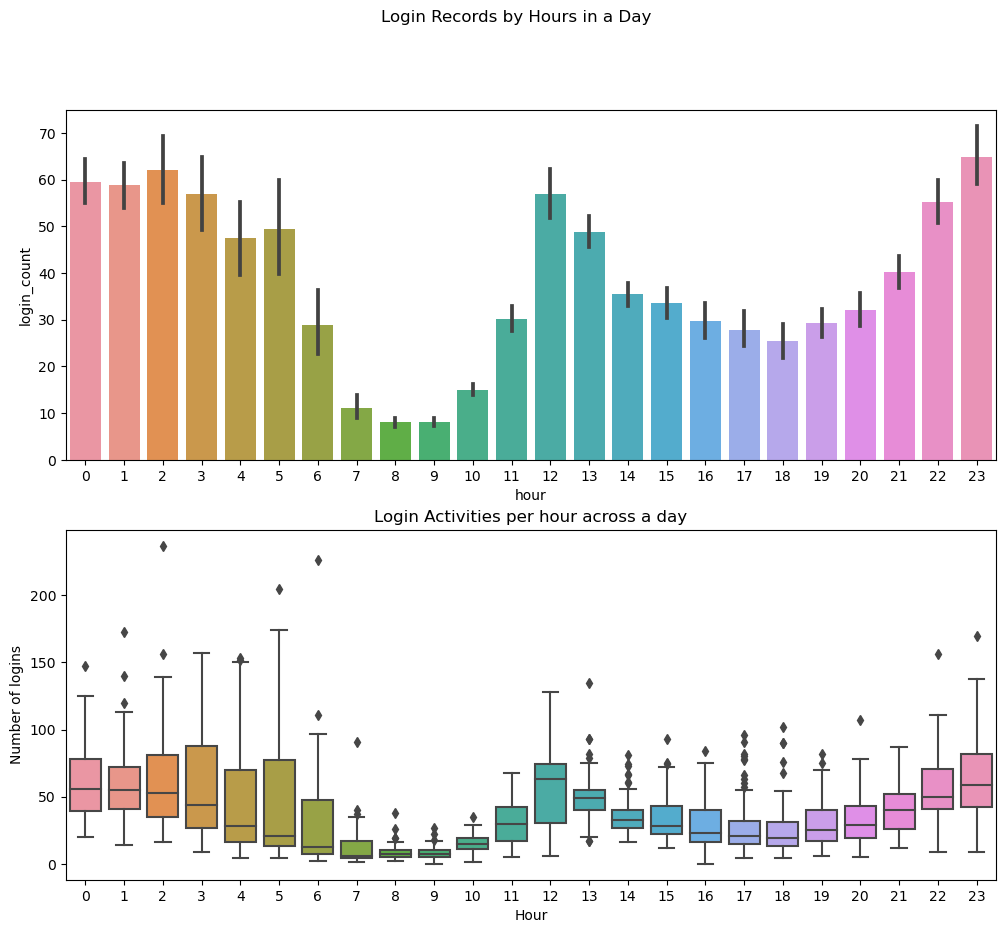

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
plt.suptitle('Login Records by Hours in a Day')

sns.barplot(x='hour', y='login_count', data=dfhour, ax=axes[0])
sns.boxplot(x='hour', y='login_count', data=dfhour, ax=axes[1])
plt.title("Login Activities per hour across a day")
plt.xlabel("Hour")
plt.ylabel("Number of logins")
plt.xticks(rotation=0);

The login activity is minimum during the morning hours (6AM to 9AM), then it uprises. The peak in login activities are observed during the night hours (12PM to 4AM).

### Login Activity across the Days by Month and Weeks:

In [14]:
dfday= df.resample('1D', label='right', closed='right').sum()
dfday['time'] = pd.to_datetime(dfday.index)
dfday['day'] = dfday.time.dt.day
dfday['week'] = dfday.time.dt.isocalendar().week.astype(str)
dfday['weekday'] = dfday.time.dt.day_name(locale = 'English')
dfday['month'] = dfday.time.dt.month_name()
dfday.head(40)

,login_count,time,day,week,weekday,month
login_time,,,,,,
1970-01-02,112,1970-01-02,2,1,Friday,January
1970-01-03,681,1970-01-03,3,1,Saturday,January
1970-01-04,793,1970-01-04,4,1,Sunday,January
1970-01-05,788,1970-01-05,5,2,Monday,January
1970-01-06,459,1970-01-06,6,2,Tuesday,January
1970-01-07,536,1970-01-07,7,2,Wednesday,January
1970-01-08,648,1970-01-08,8,2,Thursday,January
1970-01-09,625,1970-01-09,9,2,Friday,January
1970-01-10,881,1970-01-10,10,2,Saturday,January


<AxesSubplot:xlabel='day', ylabel='login_count'>

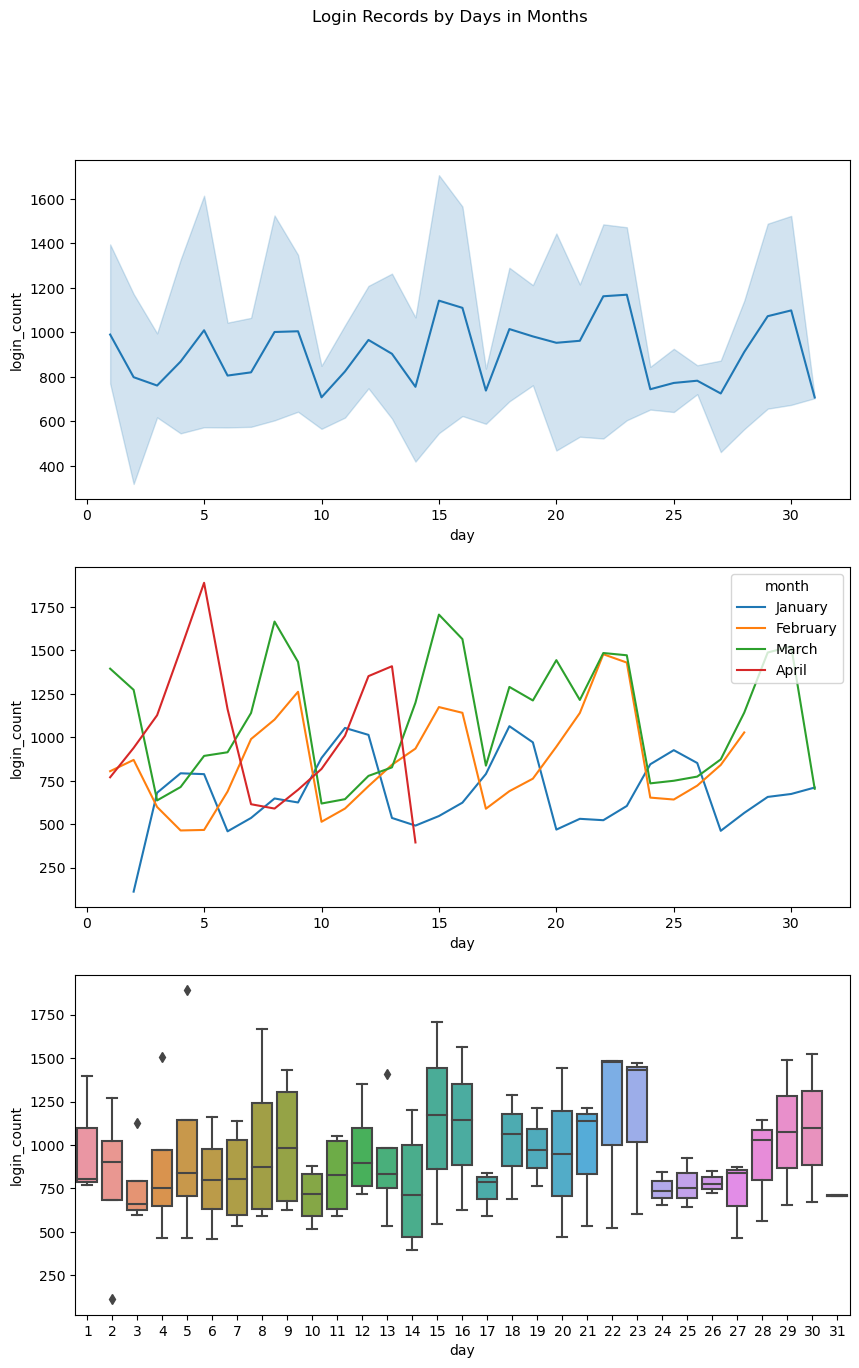

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
plt.suptitle('Login Records by Days in Months')

sns.lineplot(x='day',y='login_count', data=dfday, ax = axes[0])
sns.lineplot(x='day',y='login_count', data=dfday,hue='month',ax = axes[1])
sns.boxplot(x='day', y='login_count', data=dfday, ax = axes[2])


There exists a seasonal pattern in daywise count chart (1st graph) but not with respect to days across in month (2nd Chart). So, we will investigate to find if the pattern is across the days in the week.

<AxesSubplot:xlabel='weekday', ylabel='login_count'>

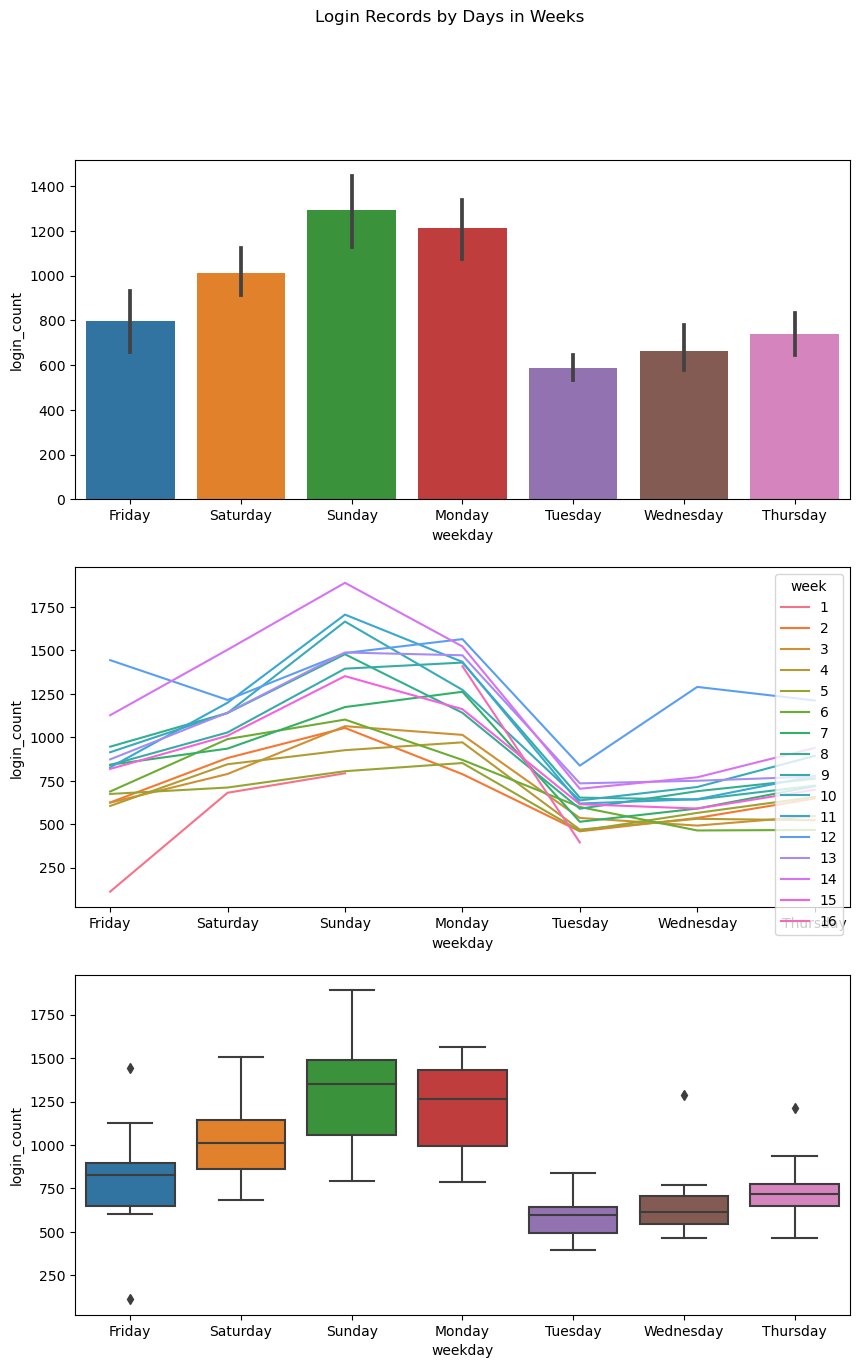

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
plt.suptitle('Login Records by Days in Weeks')

sns.barplot(x='weekday',y='login_count', data=dfday, ax = axes[0])
sns.lineplot(x='weekday',y='login_count', data=dfday,hue='week',ax = axes[1])
sns.boxplot(x='weekday', y='login_count', data=dfday, ax = axes[2])


The seasonality pattern has been identified across the days in the week. The highest login count is observed in Sundays, followed by Monday and Saturday. The lowest login count is in Tuesdays.

### Login Activity across the Weeks and Months:

In [17]:
dfweek= df.resample('W-MON', label='right', closed='right').sum()
dfweek['time'] = pd.to_datetime(dfweek.index)
dfweek['week'] = dfweek.time.dt.isocalendar().week.astype(str)
dfweek['month'] = dfweek.time.dt.month_name()
dfweek.head(20)

,login_count,time,week,month
login_time,,,,
1970-01-05,2833,1970-01-05,2,January
1970-01-12,5294,1970-01-12,3,January
1970-01-19,4956,1970-01-19,4,January
1970-01-26,4744,1970-01-26,5,January
1970-02-02,4881,1970-02-02,6,February
1970-02-09,5487,1970-02-09,7,February
1970-02-16,5990,1970-02-16,8,February
1970-02-23,7099,1970-02-23,9,February
1970-03-02,6538,1970-03-02,10,March


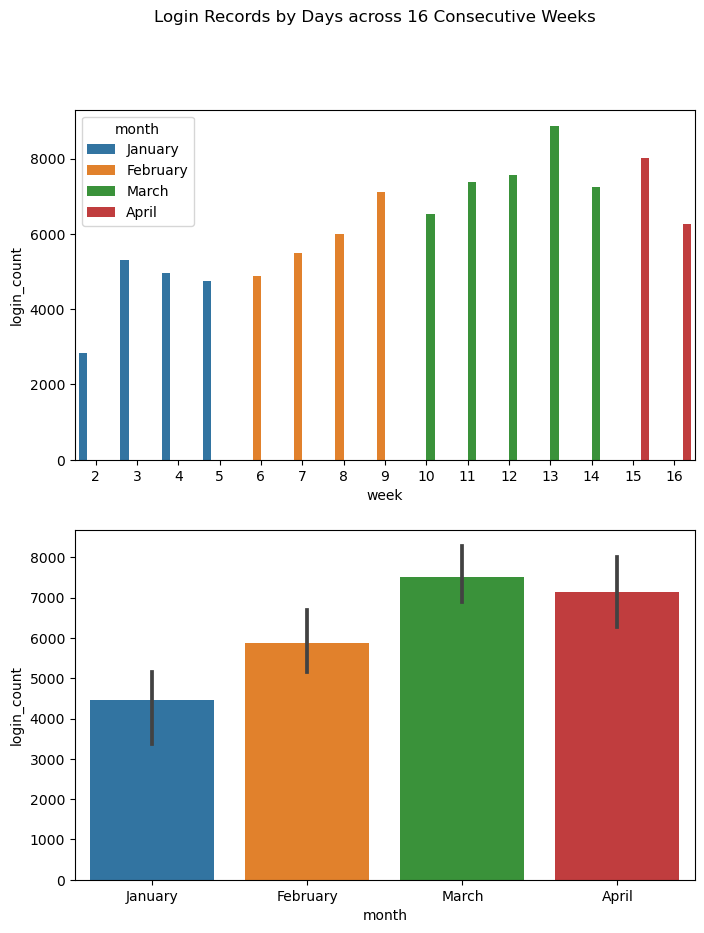

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
plt.suptitle('Login Records by Days across 16 Consecutive Weeks')

sns.barplot(x='week',y='login_count', data=dfweek, hue='month', ax = axes[0])
sns.barplot(x='month',y='login_count', data=dfweek, ax = axes[1]);

Login Count was highest at week 13 i.e. March and April has record for 2 weeks in this dataset.

#### Observation From the Graphs:

1. The data set has observation missing from last 2 weeks in April.
2. The login activity is minimum during the morning hours (6AM to 9AM), then it uprises. The peak in login activities are observed during the night hours (12PM to 4AM).
3. The highest login count is observed in Sundays, followed by Monday and Saturday. The lowest login count is in Tuesdays.
4. Login Count was highest at week 13 i.e. March and April has record for 2 weeks in this dataset.

__________________________________________________________________________________________________________

# Part 2 ‐ Experiment and metrics design:

><font color='green'>**Problem Statement**-
>
>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
>
>1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
>
>2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. 
>
>Please provide details on:
>
>a) how you will implement the experiment
>
>b) what statistical test(s) you will conduct to verify the significance of the
observation
>
>c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.
>
>Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.
>
</font>


Answer:

1) Whatever business index involved with profit/ revenue can be considered as key index of success in this case. For example, an analysis on following indices can provide insights after this initiative been taken: 
   
    * Has the Number of trips increased?
    * Has the Rating for the drivers become better?
    * Has been the users more interested to use **Ultimate** sevices in the first 30 days and onwards also?
    * Has the rider been consistent with his positive attitude towards **Ultimate**?

2. The asserted initive by the Ultimate managers was a proposal of *an experiment to encourage driver partners to be available in both cities, by reimbursing all toll* .

Considering only the 'Number of trips' factor, let us assume:

$ {\bar{x}}_{\text{before}} $ = Average number of trips before starting reimbursing toll, and

$ {\bar{x}}_{\text{after}} $ = Average number of trips after starting reimbursing toll.

Our success criteria of this experiment should be if we can statistically prove that **$ {\bar{x}}_{\text{before}} <  {\bar{x}}_{\text{after}}$ i.e. there exists significant increase in number of trips after this initiative has been taken.**

We can state the Null and Alternative Hypothesis as-

 Null Hypothesis, $H_0 : {\bar{x}}_{\text{before}} \geq {\bar{x}}_{\text{after}} $, i.e. no effect of the experiment.

 Alt. Hypothesis, $H_1 : {\bar{x}}_{\text{before}} < {\bar{x}}_{\text{after}} $ i.e. positive effect of the experiment.

*Test Statistics:* 

1. On the assumption that this experiment is conducted on the same observations () in a before-after scenario, this would be a *Paired t-test*.
2. This will be a one tailed and right/ upper tailed test. 
3. The general consideration of threshold level of significance/ cutoff point for $\alpha$ = 5% = 0.05.

If the calculated Z value (from sample data) is > 1.645 at $\alpha$ = 0.05, we reject the null hypothesis i.e. accept the alternative hypothesis stating that the initiative was sucessful.

The caution should be taken with the testing considering the following :

* The dataset should be large enough (greater than 20 records, more larger more better).
* The decision rule is: Reject $H_0$ if Z > 1.645.
* Decide the test performance by type 1 or type 2 error.

__________________________________________________________________________________________________________

# Part 3 ‐ Predictive Modeling:

><font color='green'>**Problem Statement**-
>
>Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
>
>We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
>
>1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
>
>2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
>
>3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).
>
>
</font>


 Data description-

 * city: city this user signed up in
 * phone: primary device for this user
 * signup_date: date of account registration; in the form ‘YYYY MM DD’
 * last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
 * avg_dist: the average distance in miles per trip taken in the first 30 days after signup
 * avg_rating_by_driver: the rider’s average rating over all of their trips
 * avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
 * surge_pct: the percent of trips taken with surge multiplier > 1
 * avg_surge: the average surge multiplier over all of this user’s trips
 * trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
 * ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
 * weekday_pct: the percent of the user’s trips occurring during a weekday

## Solution:

In [19]:
%reset -f

### Import Necessary Libraries:

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

### Import Dataset:

In [21]:
df = pd.read_json('ultimate_data_challenge.json')

### Data Wrangling:

In [22]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Dealing with Missing Values:

In [24]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [25]:
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


In [26]:
#df[df['avg_rating_of_driver'].isnull()]
#df[df['phone'].isnull()]
#df[df['avg_rating_of_driver'].isnull()]

We see that- 
* In column 'avg_rating_of_driver' 8122 records had NaN, we will drop those rows.
* In column 'phone' 396 records had 'None' as NaN, we replace it with 'Unknown'.
* In column 'avg_rating_by_driver' had 201 records as NaN, we will drop those rows.


In [27]:
df=df.dropna(subset=['avg_rating_of_driver','avg_rating_by_driver'])
df['phone'] = df['phone'].fillna('Unknown')

In [28]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

##### Change Datatype:

In [29]:
df["signup_date"] = pd.to_datetime(df["signup_date"] ,infer_datetime_format=True)
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"] ,infer_datetime_format=True)

In [30]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41744 non-null  object        
 1   trips_in_first_30_days  41744 non-null  int64         
 2   signup_date             41744 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               41744 non-null  float64       
 5   last_trip_date          41744 non-null  datetime64[ns]
 6   phone                   41744 non-null  object        
 7   surge_pct               41744 non-null  float64       
 8   ultimate_black_user     41744 non-null  bool          
 9   weekday_pct             41744 non-null  float64       
 10  avg_dist                41744 non-null  float64       
 11  avg_rating_by_driver    41744 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

#### Feature Engineering:

##### Insert new column:

As mentioned in the problem statement- users who signed up for an Ultimate account is considered as **retained** if they were “active” (i.e. took a trip) in the preceding 30 days. The goal of this study is predicting rider retention.

> "The sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active_status” (i.e. took a trip) in the preceding 30 days."

In [32]:
# make a copy of dataset for analysis

newdf = df.copy()

In [33]:
newdf.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [34]:
# find the date the data was pulled
pull_date = newdf.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# add active status to dataframe 0= inactive, 1 = active
newdf['active_status'] = (newdf.last_trip_date > cut_off_day).astype('int')

In [35]:
newdf['active_status'].sum()/len(newdf['active_status'])*100

40.07282483710234

The dataset is slightly imbalanced, so it may not need upsampling.

In [36]:
newdf['active_status'].head(10)

0     1
1     0
2     0
3     1
4     0
5     1
7     0
8     0
10    0
11    0
Name: active_status, dtype: int32

<AxesSubplot:xlabel='city', ylabel='count'>

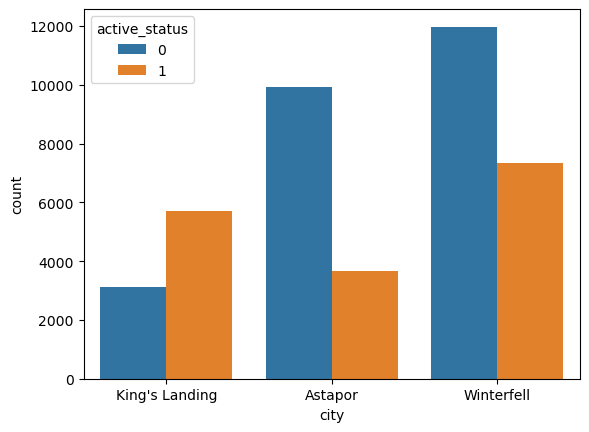

In [37]:
sns.countplot(data=newdf, x='city', hue='active_status')

<AxesSubplot:xlabel='phone', ylabel='count'>

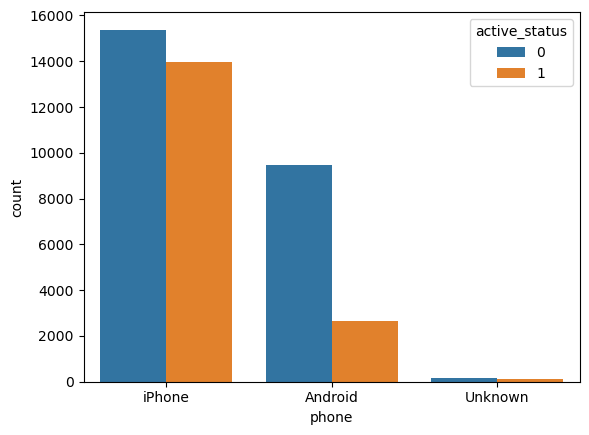

In [38]:
sns.countplot(data=newdf, x='phone', hue='active_status')

<AxesSubplot:xlabel='ultimate_black_user', ylabel='count'>

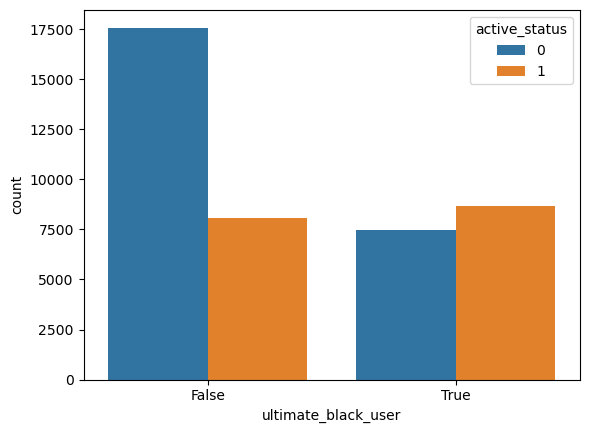

In [39]:
sns.countplot(data=newdf, x='ultimate_black_user', hue='active_status')

Observation:

From the charts above, we can interprete that- the riders from Winterfell are more likely seen to stay active for 6 months. Also, riders who are active are mostly Iphone users. The **Ultimate Black Users** are not observed to be interested in staying active for 6 months. 

### Feature Analysis:

In [40]:
# drop the unnecessary columns:
newdf = newdf.drop(['signup_date', 'last_trip_date'], axis=1)

# add dummies to categorical data
newdf = pd.get_dummies(newdf, columns = ['city', 'phone','ultimate_black_user'])

In [41]:
newdf.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Unknown,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,1,0,1,0,0,0,1,0,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,0,1,0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,0,1,0,0,0,0,1,1,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,1,0,1,0,0,0,1,0,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,0,1,1,0,0,1,0


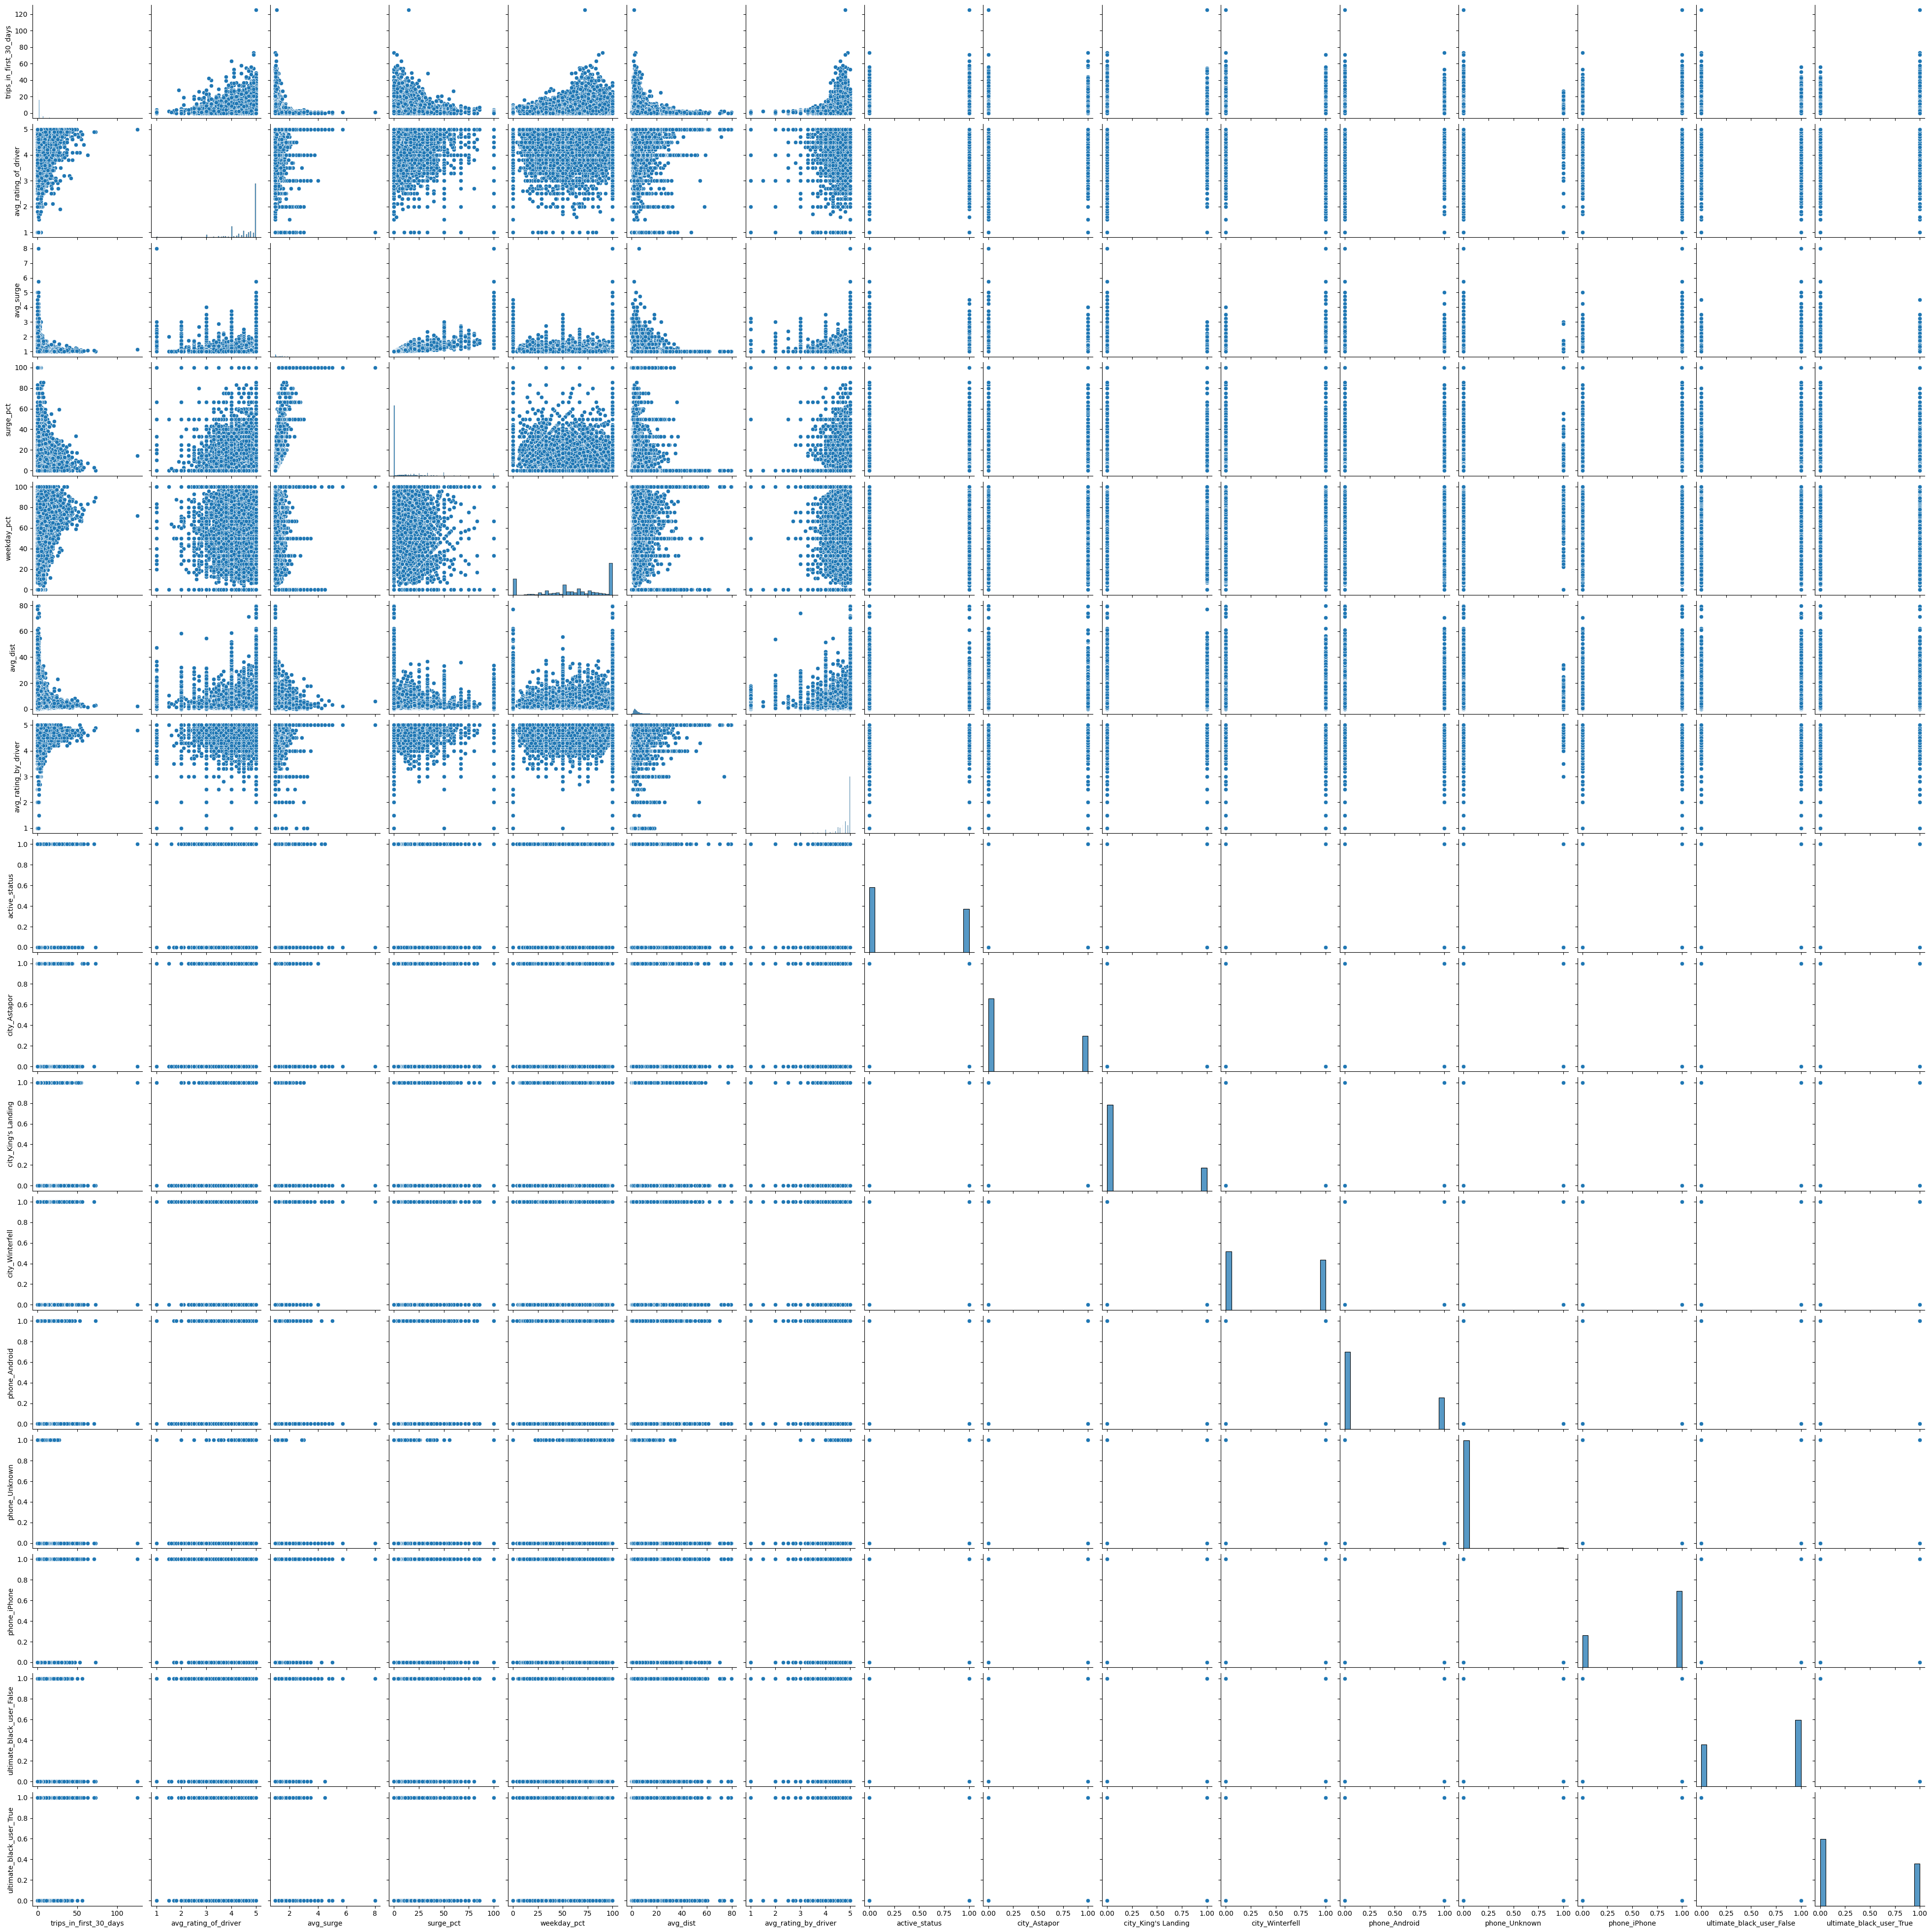

In [42]:
#select out only continuous variables
newdf_pp = newdf[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
           'surge_pct', 'trips_in_first_30_days', 'weekday_pct']]

#plot
sns.pairplot(newdf)
plt.show()

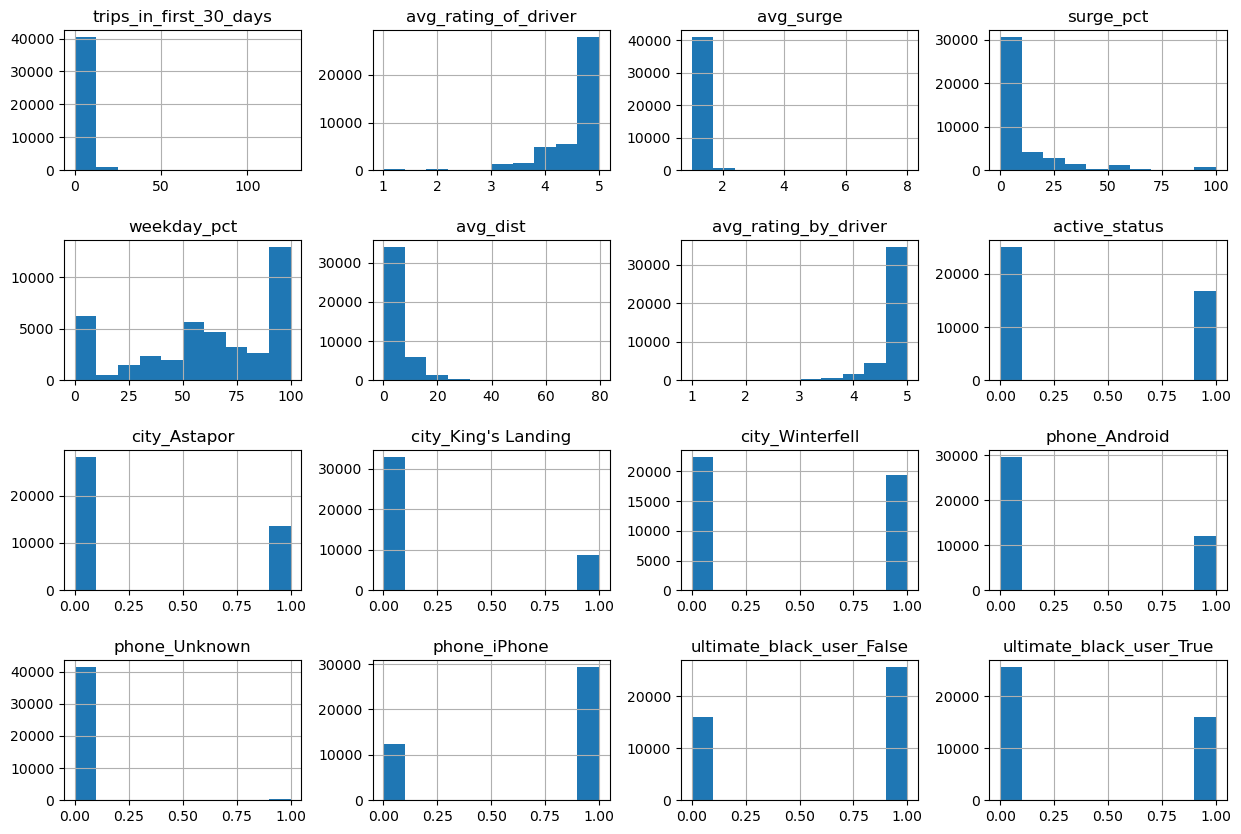

In [43]:
newdf.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
plt.show()

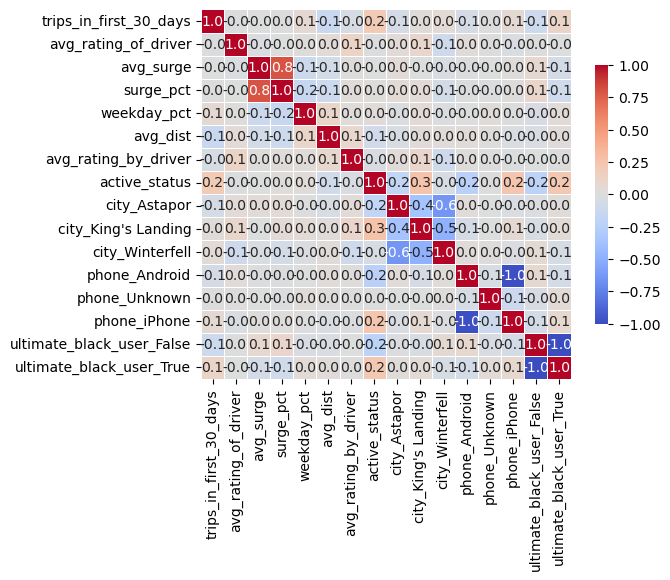

In [44]:
sns.heatmap(newdf.corr(), cmap='coolwarm', vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7},
            annot=True,
            fmt=".1f"
           );
plt.show()

There exists a correlation among the columns as below:

* avg_surge and surge_pct,
* the three cities Astapor, King's Landing and Winterfell,
* phone type Android and Iphone,
* Ultimate Black users (True and False)


So, in this case, *Logistic regression might not be the best option for modelling multicorrelated data.*

### Train and Test Split of Data:

In [45]:
# Final Selection of columns for X and y:

X = newdf.drop(['active_status'], axis=1)
y = newdf['active_status']

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [47]:
X_train.shape, X_test.shape

((31308, 15), (10436, 15))

In [48]:
y_train.shape, y_test.shape

((31308,), (10436,))

### Scaling Numerical Variables:

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

standrdiz = ColumnTransformer(transformers=[('scale', MinMaxScaler(), [
"trips_in_first_30_days",
"avg_rating_of_driver",	
"avg_surge",	
"surge_pct",
"weekday_pct",	
"avg_dist",	
"avg_rating_by_driver"]),],remainder="passthrough")

X_train = standrdiz.fit_transform(X_train)
X_test = standrdiz.transform(X_test)

#### Modelling:

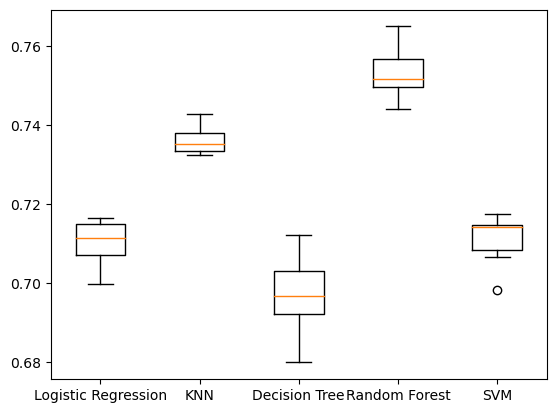

In [50]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {"Logistic Regression": LogisticRegression(solver = 'newton-cg', max_iter = 500, C = 1000),
          "KNN": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "SVM": SVC(gamma='auto')
          }

results = []

for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)


plt.boxplot(results, labels= models.keys())
plt.show()

#### Check the Performance Matrix:

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

for name, model in models.items():
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    prediction = model.predict(X_test)
    report = classification_report(prediction, y_test)
    mat = confusion_matrix(prediction, y_test)
    print("{} Test Set Accuracy: {}".format(name, test_score))
    print("{} Confusion Matrix:\n{}".format(name, mat))
    print("{} Classification Report:\n{}".format(name, report))

Logistic Regression Test Set Accuracy: 0.7127251820620928
Logistic Regression Confusion Matrix:
[[5157 1898]
 [1100 2281]]
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      7055
           1       0.55      0.67      0.60      3381

    accuracy                           0.71     10436
   macro avg       0.69      0.70      0.69     10436
weighted avg       0.73      0.71      0.72     10436

KNN Test Set Accuracy: 0.7413760061326179
KNN Confusion Matrix:
[[5007 1449]
 [1250 2730]]
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      6456
           1       0.65      0.69      0.67      3980

    accuracy                           0.74     10436
   macro avg       0.73      0.73      0.73     10436
weighted avg       0.74      0.74      0.74     10436

Decision Tree Test Set Accuracy: 0.6977769260252971
Decision T

#### Finding Important Features:

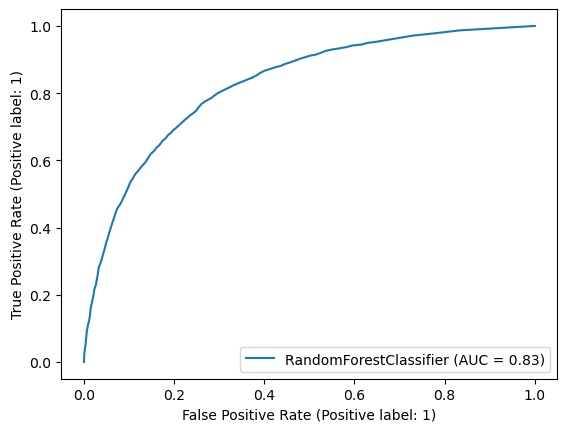

In [52]:
from sklearn.metrics import RocCurveDisplay

rf=RandomForestClassifier()
rf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(rf, X_test, y_test)

Comment:

From the performance metrices above, we see that Random Forest Classifier performs best in terms of both Accuracy (75%) and f1score (0.80). This model can be a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system.

It is the call for the business decision to prioritize who should be the priority for business initiatives- those who are expected to retain next six months will leave or those who are expected to leave in next 6 months will retain.   

Text(0.5, 1.0, 'Important Features')

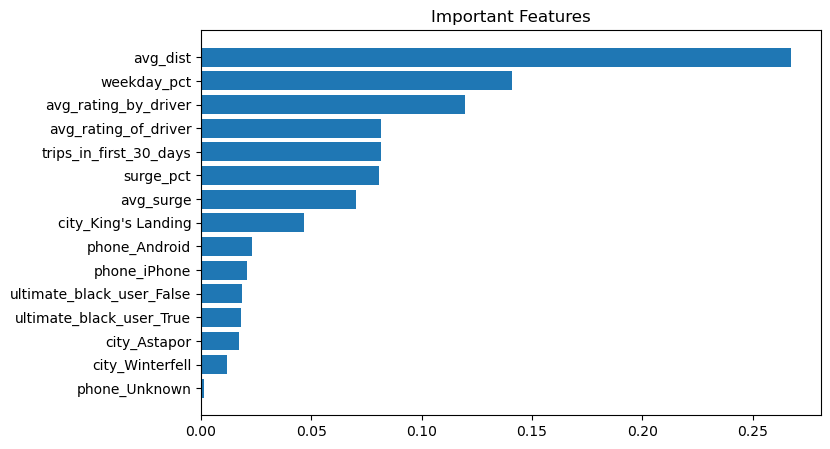

In [53]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Important Features')

* avg_dist: the average distance in miles per trip taken in the first 30 days after signup,
* weekday_pct: the percent of the user’s trips occurring during a weekday,
* avg_rating_by_driver: the rider’s average rating over all of their trips

# Conclusion:

To improve long-term rider retention, Ultimate need improve in the following aspects:

* The most important feature for retaining riders is to find ways to attract riders to take longer trips during the first 30 days after signup.
* The business initiative should focus on to persuade riders to take trips during weekdays.
* Ultimate should focus more on to retaining the high rated riders by providing better service to them.

**********************************************************************************************************